<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 7</h1>

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import layers, activations

from keras.layers import Input, Flatten, Dense, Rescaling, MaxPooling2D, Conv2D, Dropout

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - CNN classifier</h1>

L'obiettivo di questo esercizio è la costruzione di un semplice ***CNN classifier***, ossia una rete neurale particolarmente efficace per l'elaborazione di dati strutturati in griglie, come per esempio le immagini. Una CNN è caratterizzata da una struttura articolata, dato che solitamente presenta:

- **layer convoluzionali:** applicano dei filtri che scansionano l'immagine e servono ad estrarre caratteristiche locali

- **pooling layer:** riduce la dimensione dell'immagine, mantenendo tuttavia le caratteristiche principali della stessa. Questo processo rende la rete più efficiente e robusta

- **fully connected layers:** prendono come input le caratteristiche estratte nella fase di convoluzione e fanno la classificazione finale

Dimensione training data: (50000, 32, 32, 3)
Dimensione training label: (50000, 1)

Dimensione validation data: (10000, 32, 32, 3)
Dimensione validation label: (10000, 1)


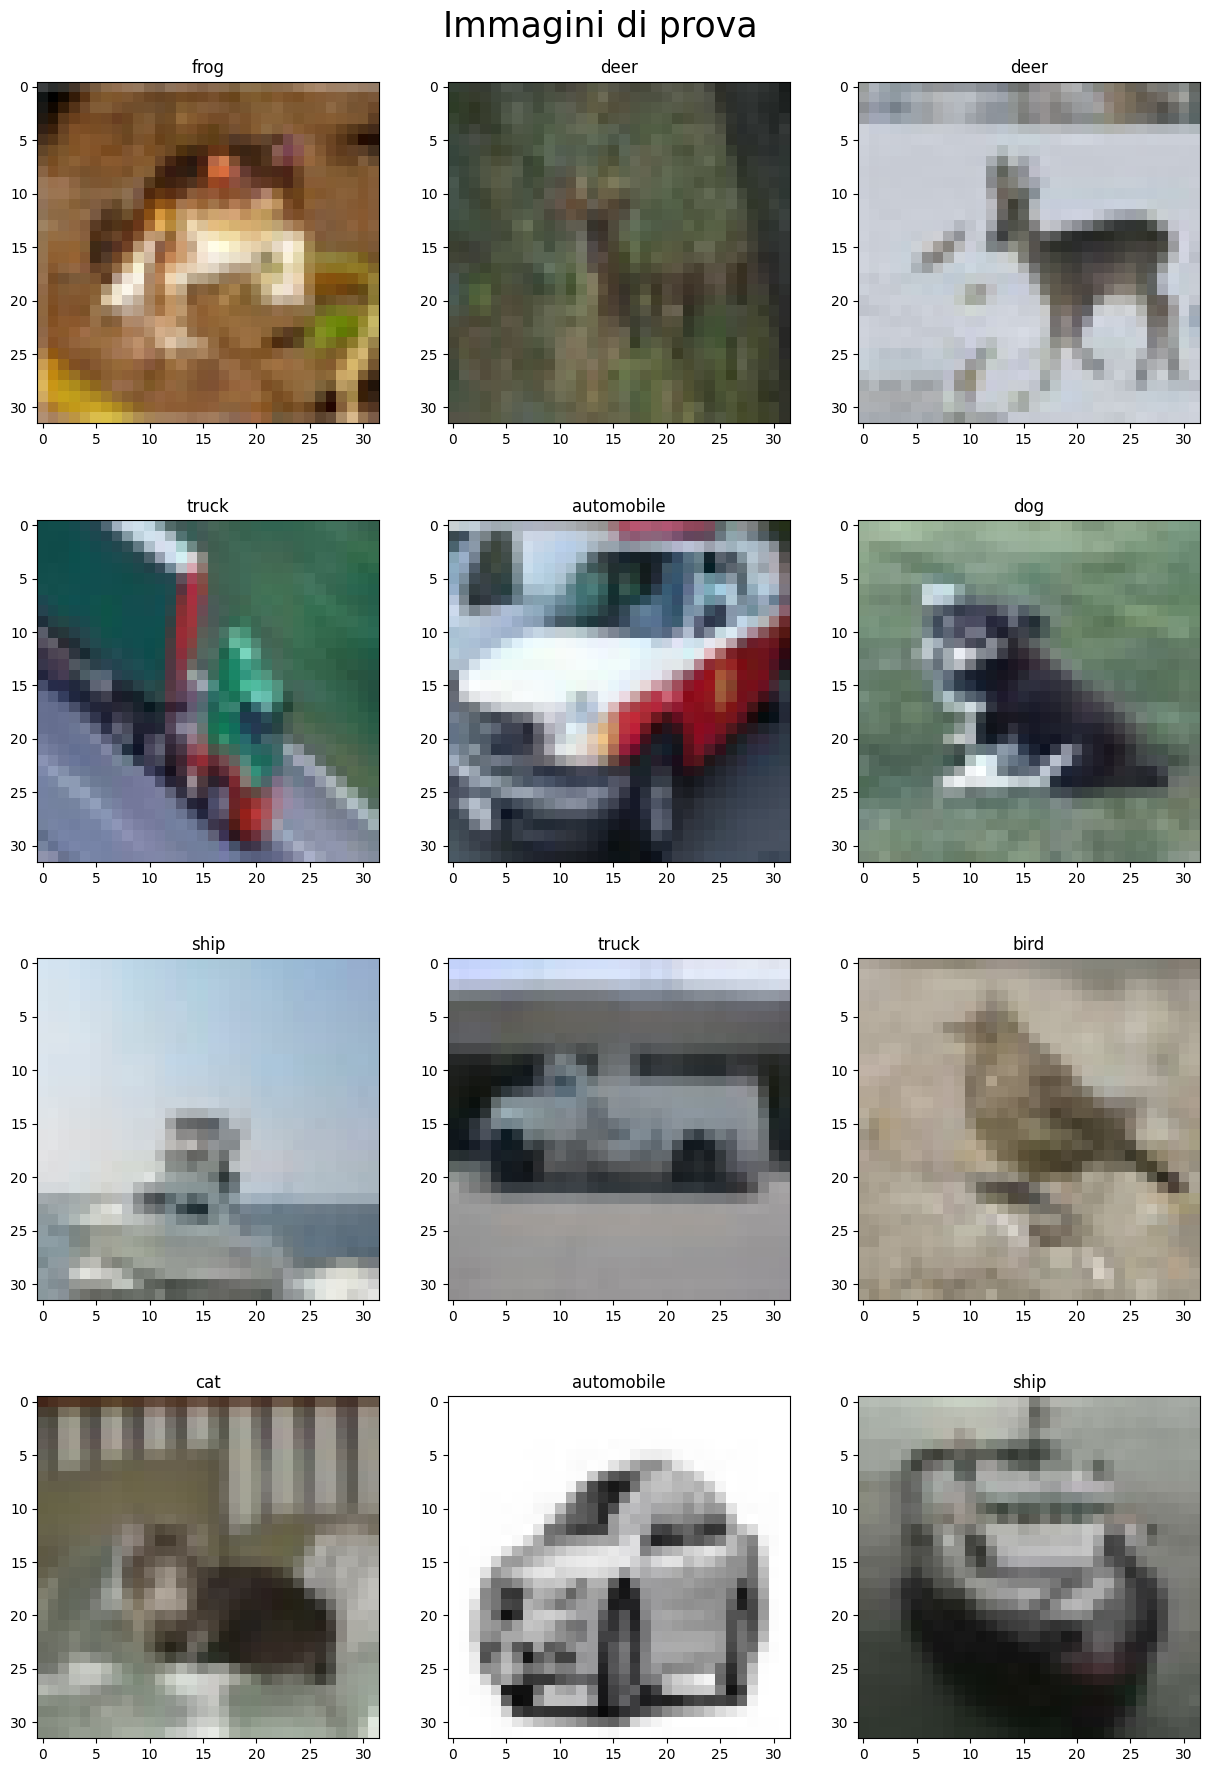

In [13]:
def printImg(imTr, clTr, classes):
    # Funzione per stampare alcune immagini di prova del dataset
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(imTr[50*i+10*j])
            ax[i][j].set_title(classes[clTr[50*i+10*j, 0]])

    fig.suptitle("Immagini di prova", fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


# Ci poniamo di risolvere un problema di classificazione e questo vuol dire che avremo a 
# che fare con delle immagini. In primo luogo dobbiamo caricare il dataset in modo da poterlo
# analizzare. Utilizziamo il dataset cifar, che possiamo direttamente importare da keras. 
# Questo dataset contiene 60mila immagini a bassa definizione contenenti 10 classi di oggetti, ossia
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']. Il 
# dataset è diviso in due: 50mila immagini per la fase di allenamento della rete e 10mila immagini per
# quella di validation
(imTr, clTr), (imVal, clVal) = cifar10.load_data()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Studio la dimensione dei  vari dataset scaricati e stampo alcune immaigni di prova
print("Dimensione training data:", imTr.shape)
print("Dimensione training label:", clTr.shape)
print("\nDimensione validation data:", imVal.shape)
print("Dimensione validation label:", clVal.shape)

printImg(imTr, clTr, classes)

/home/filippo/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25


2025-06-29 13:07:51.521092: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.2730 - loss: 1.9702 - val_accuracy: 0.3543 - val_loss: 1.7606
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.3748 - loss: 1.7274 - val_accuracy: 0.4161 - val_loss: 1.6359
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4008 - loss: 1.6585 - val_accuracy: 0.4231 - val_loss: 1.6269
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4155 - loss: 1.6173 - val_accuracy: 0.4234 - val_loss: 1.6212
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4301 - loss: 1.5833 - val_accuracy: 0.4431 - val_loss: 1.5722
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.4332 - loss: 1.5730 - val_accuracy: 0.4309 - val_loss: 1.5882
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4462 - loss: 1.5451 - val_accuracy: 0.4151 - val_loss: 1.6273
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.4422 - loss: 1.54

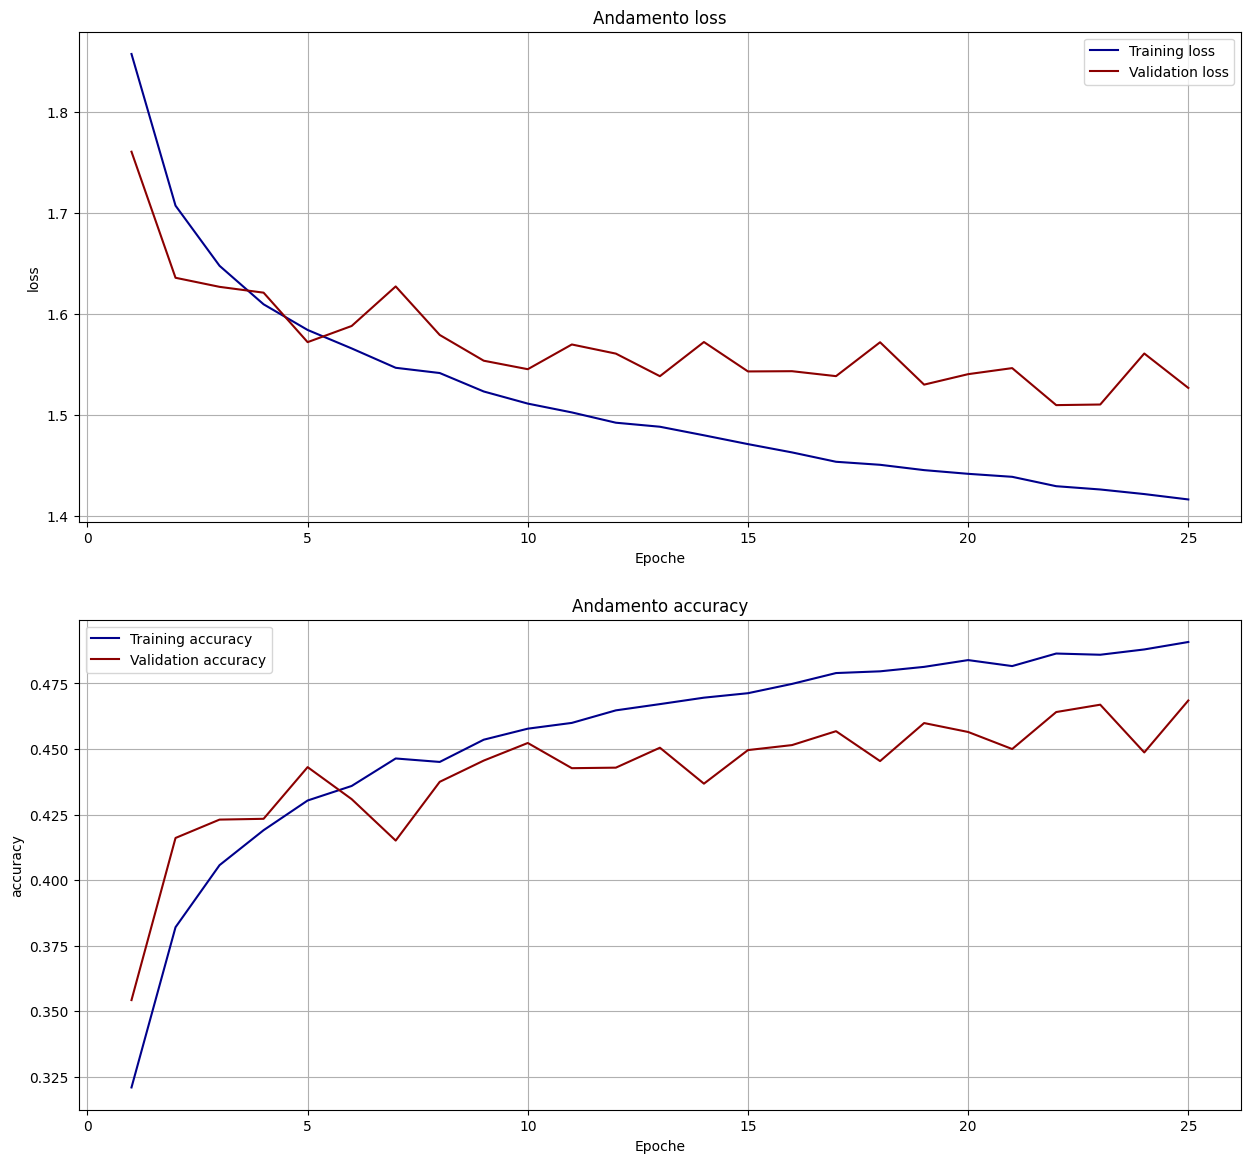

In [19]:
def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()


def builMod(imH, imW, numcl):
    # Funzione per costruire un classificatore che non presenta alcun layer convoluzionale. 
    # Ci immaginiamo che il modello abbia delle performance abbastanza scarse, perchè non sfrutta 
    # alcuna caratteristica locale per la classificazione

    model = keras.Sequential()

    model.add(Rescaling(1./255, input_shape=(imH, imW, 3)))
    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(numcl, activation = 'softmax'))

    return model


# Costruzione del modello ed allenamento della rete
model = builMod(32, 32, 10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(imTr, clTr, epochs=25, validation_data=(imVal, clVal))
plotTrInfo(hist)

Epoch 1/25


2025-06-29 14:26:28.142875: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 191s 118ms/step - accuracy: 0.3675 - loss: 1.7171 - val_accuracy: 0.5548 - val_loss: 1.2382
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.5784 - loss: 1.1859 - val_accuracy: 0.6004 - val_loss: 1.1063
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.6352 - loss: 1.0298 - val_accuracy: 0.6347 - val_loss: 1.0270
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.6729 - loss: 0.9318 - val_accuracy: 0.6657 - val_loss: 0.9595
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - accuracy: 0.6954 - loss: 0.8653 - val_accuracy: 0.6635 - val_loss: 0.9860
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.7142 - loss: 0.8050 - val_accuracy: 0.6808 - val_loss: 0.9178
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.7423 - loss: 0.7347 - val_accuracy: 0.6731 - val_loss: 0.9700
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.7577 - loss: 0.

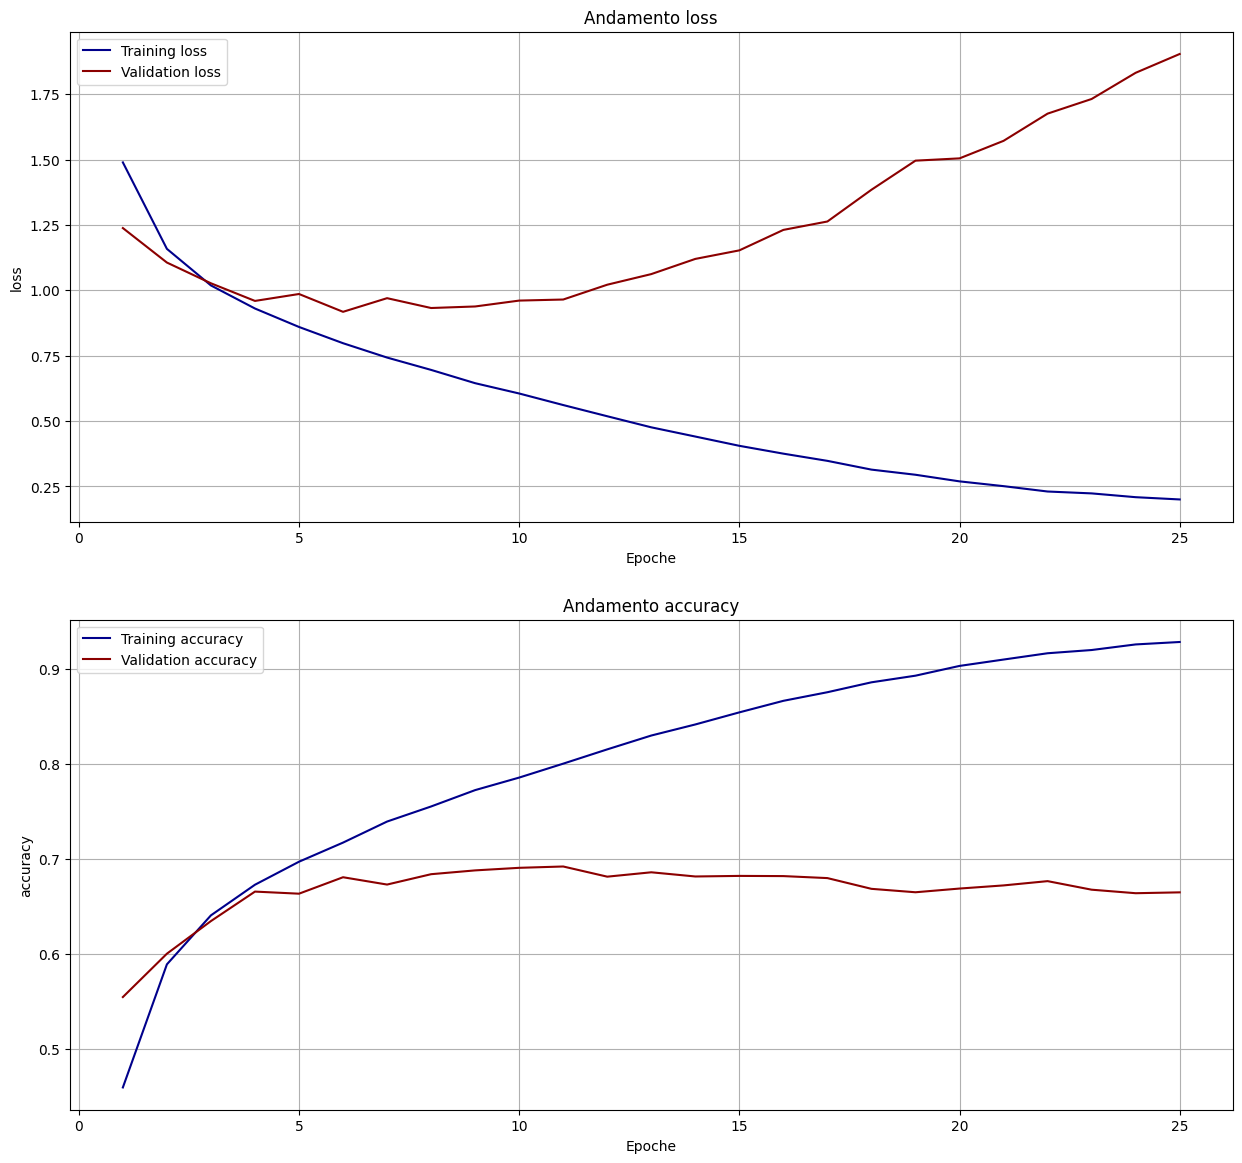

In [23]:
def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()

def builMod(imH, imW, numcl):
    # Funzione per costruire il modello in questione. 

    model = keras.Sequential()
    # In primo luogo è necessario normalizzare le immagini fornite come input al modello e per 
    # questo motivo dividiamo il tutto per 255 ossia il massimo valore che può avere un pixel secondo 
    # la codifica RGB. Inoltre le immagini di input sono die tensori tridimensionali perchè per 
    # ogni pixel è necessario specificare la quantità di rosso, verde e blu.
    model.add(Rescaling(1./255, input_shape=(imH, imW, 3)))
    # Per i layer convoluzionali utilizzaimo Conv2D, che crea un kernel convoluzionale che è in 
    # convoluzione con l'input su uno spazio 2D (larghezza e lunghezza). In particolare specifichiamo:
    #
    # filters --> il numero di filtri da applicare. Ogni filtro si dedica all'individuazione di 
    # una caratteristica differente, quindi "più filtri == più caratteristiche 
    # imparate"
    #
    # kernel_size --> specifica le dimensioni del filtro, quindi larghezza ed altezza
    #
    # Si possono anche specificare altri parametri quali la funzione d'attivazione
    model.add(Conv2D(16, (3, 3), activation = 'relu'))
    # Dopo uno strato convozionale introduciamo un layer di pooling, il cui scopo è quello di 
    # rendere più efficiente la rete neurale, dato che la dimensione delle immagini vinee ridotta, 
    # mantenendo tuttavia le caratteristiche principali. Questo vuol dire che le successive analisi 
    # saranno più immmediate. Un parametro importante da segnalare è il "pool_size", che definisce 
    # le dimensioni della finestra di campionamento
    model.add(MaxPooling2D((2, 2)))
    # Per rendere lo studio dell'immagine più accurato inserisco altri layer convoluzionali e di 
    # pooling, in modo da caratterizzare altre features
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    # Inizia ora la parte fully connected per la classificazione delle immagini
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numcl, activation = 'softmax'))
    
    return model


# Costruzione del modello ed allenamento della rete
model = builMod(32, 32, 10)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(imTr, clTr, epochs=25, validation_data=(imVal, clVal))
plotTrInfo(hist)